# Homework \#5
Name: Jonas Schweisthal \
Student number: s4535561

In [1]:
from model import Model
from dmchunk import Chunk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math

In [2]:
def noise(s):
    rand = random.uniform(0.001,0.999)
    return s * math.log((1 - rand)/rand)

In [3]:
def time_to_pulses(time, t_0 = 0.011, a = 1.1, b = 0.015):
    pulses = 0
    pulse_duration = t_0
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses += 1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return pulses

In [4]:
def pulses_to_time(pulses, t_0 = 0.011, a = 1.1, b = 0.015):
    time = 0
    pulse_duration = t_0
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return time

In [5]:
# Perform Experiments: 
def ready_set_go(n_participants, experiment):
    '''
         Simulates experiments 1 or 2 of Acerbi et al. (2012)

                Parameters:
                        a (int): number of participants conducting the experiment
                        b (int[1 or 2]): number defining the selected experiemnt

                Returns:
                        df (pandas.DataFrame): DataFrame containing the results of the experiment
    '''
    # number of subjects
    subjects = range(1,n_participants+1)
    if experiment == 1:
        # short, long
        conditions = ["Short Uniform", "Long Uniform"] 
    elif experiment == 2:
         # medium uniform, medium peaked
        conditions = ["Medium Uniform", "Medium Peaked"]
    # defining dataframe
    df = pd.DataFrame(columns = ["Line", "Subj", "Cond", "Session", "Run", "Trial", "Ts", "Tp", "Main"])
    main = False
    line = 0
    for subj in subjects:
        # shuffling order of conditions randomly per subject
        np.random.shuffle(conditions)
        # own condition and model per subject as there is probably a long time between the two conditions
        for cond in conditions:
            m = Model()
            session = 1
            # set up for stopping if fractional change in mean squared timing error between sessions less than 0.08
            change_error = 1
            while change_error >= 0.08: 
                
                # between 5 and 6 runs per session a ~500 trials
                for run in np.arange(1, np.random.choice([5, 6])+1):
                    # between 84 and 96 trials per run
                    for trial in np.arange(1, np.random.randint(84, 97)):
                        
                        line += 1
                        # educated guess of about 2 seconds preparation time between trials
                        m.time += 2 
                        
                        # draw out of 6 discrete values of discrete uniform distribution per condition
                        if cond == "Short Uniform":
                            ts = np.random.choice(np.linspace(0.45, 0.825, 6)).round(3) # rounding just for computational rounding errors necessary
                        elif cond == "Long Uniform":
                            ts = np.random.choice(np.linspace(0.75, 1.125, 6)).round(3)
                        elif cond == "Medium Uniform":
                            ts = np.random.choice(np.linspace(0.600, 0.975, 6)).round(3)
                        elif cond == "Medium Peaked":
                            ts = np.random.choice(np.linspace(0.600, 0.975, 6), 
                                                 p = [1/12, 7/12, 1/12, 1/12, 1/12, 1/12]).round(3)
                        m.time += ts

                        # time to pulses 
                        pulses = time_to_pulses(ts)
                        fact = Chunk(name = "pf" + str(pulses), slots ={"isa":"pulses-fact", "pulses": pulses})
                        # adding encounter of the perceived interval as pulses at the end time point of the presented interval
                        m.add_encounter(fact)
                        # flash time of 0.0185 seconds 
                        m.time += 0.0185
                        # adding time of 250 ms for minimum waiting after flash 
                        # 5ms time for storing encounter included here (simultaneously)
                        m.time += 0.250
                        
                        # retrieving blended trace
                        request = Chunk(name = "retrieve", slots = {"isa": "pulses-fact"})
                        pulses_retrieved, latency = m.retrieve_blended_trace(request, "pulses")
                        # m.time += latency is NOT added as discussed in supervision session
                        # converting blended trace of retrieved pulses to seconds
                        tp = pulses_to_time(pulses_retrieved)
                        # adding prodcution error for motoric mouseclicking of retrieved intervall possible
                        # here no error is added because
                        # adding production time
                        m.time += tp
                        
                        # random delay continuos random uniform distribution till feedback
                        delay = np.random.uniform(0.45, 0.85)
                        m.time += delay
                        # adding time of feedback
                        m.time += 0.062
                        # adding time fixation cross disappearing
                        m.time += np.random.uniform(0.5, 0.75)
                        # adding time for blank screen 
                        m.time += np.random.uniform(0.5, 0.75)
                        # new fixation cross signalling start of new trial
                        
                        # store times in milliseconds in dataframe
                        df.loc[line-1] = [line, subj, cond, session, run, trial, ts*1000, tp*1000, main]
                    # Subjects could take short breaks between runs, educated guess with 1 minute assumed to be realistic
                    m.time += 300                        
                        
                #checking if fractional change in mean squared timing error between sessions less than 0.08
                if change_error >= 0.08 and session >1:
                    change_error = abs(1-(((df[df.Session == session]["Tp"]-df[df.Session == session]["Ts"])**2).mean()/
                                    ((df[df.Session == session-1]["Tp"]-df[df.Session == session-1]["Ts"])**2).mean()))
                session += 1
            # set last two sessions per subject and block as Test (main = True)  
            df.loc[(df.Subj == subj) & (df.Cond == cond), 'Main'] = np.where(df.loc[(df.Subj == subj) & (df.Cond == cond), 'Session'] >
                                                                             df.loc[(df.Subj == subj) & (df.Cond == cond), 'Session'].max()-2,
                                                                            True, False)


    return df

In [6]:
# Simulating experiments 1 and 2 with 4 and 6 participants as mentioned in the paper
df_1 = ready_set_go(n_participants=4, experiment=1)
df_2 = ready_set_go(n_participants=6, experiment=2)

# changing Subject numbers for second experiment
df_2['Subj'] = df_2['Subj']+ df_1['Subj'].max() 

# combining datasets and calculating Bias
df = df_1.append(df_2, ignore_index = True)
df["Bias"] = df["Tp"] - df["Ts"]

In [7]:
# realistic numbers of sessions generated with algorithm and stopping rule
# in the paper described as between 3 and 6 sessions per condition and subject
df[df.Main == True].groupby(["Cond", "Subj"])['Session'].unique()

Cond            Subj
Long Uniform    1       [2, 3]
                2       [2, 3]
                3       [3, 4]
                4       [3, 4]
Medium Peaked   5       [2, 3]
                6       [3, 4]
                7       [3, 4]
                8       [3, 4]
                9       [3, 4]
                10      [2, 3]
Medium Uniform  5       [3, 4]
                6       [3, 4]
                7       [3, 4]
                8       [3, 4]
                9       [3, 4]
                10      [2, 3]
Short Uniform   1       [2, 3]
                2       [5, 6]
                3       [3, 4]
                4       [3, 4]
Name: Session, dtype: object

C:\Users\jonas\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\jonas\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\jonas\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


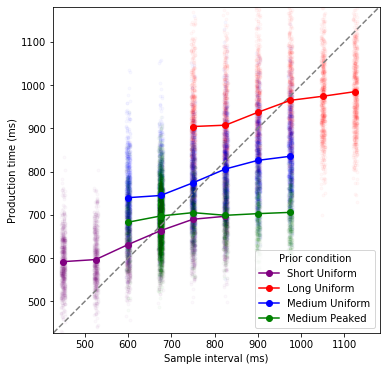

In [18]:
# Plotting Production time per Condition of both experiments
# Remove training trials
dat = df[df['Main'] == True]

# Calculate mean Tp by condition
mean_tp = dat.groupby(['Cond', 'Ts'])['Tp'].mean().reset_index()


yrange = np.multiply((min(mean_tp['Ts']), max(mean_tp['Ts'])), [0.95, 1.05])

# Subset data for plotting

cond1 = mean_tp.loc[mean_tp['Cond'] == "Short Uniform"]
cond2 = mean_tp.loc[mean_tp['Cond'] == "Long Uniform"]
cond3 = mean_tp.loc[mean_tp['Cond'] == "Medium Uniform"]
cond4 = mean_tp.loc[mean_tp['Cond'] == "Medium Peaked"]

# Add jitter noise
jitter = dat.copy()
jitter['Ts'] = jitter['Ts'] + np.random.uniform(-5, 5, len(dat))
cond1_jitter = jitter.loc[jitter['Cond'] == "Short Uniform"]
cond2_jitter = jitter.loc[jitter['Cond'] == "Long Uniform"]
cond3_jitter = jitter.loc[jitter['Cond'] == "Medium Uniform"]
cond4_jitter = jitter.loc[jitter['Cond'] == "Medium Peaked"]

# Make plot
f, ax = plt.subplots(figsize = (6,6))

ax.set(xlim = yrange, ylim = yrange)
f.gca().set_aspect('equal', adjustable = 'box')

ax.set_xlabel('Sample interval (ms)')
ax.set_ylabel('Production time (ms)')

ax.plot(yrange, yrange, linestyle = '--', color ='gray')

ax.scatter(cond1_jitter['Ts'], cond1_jitter['Tp'], marker = '.', color = 'purple', alpha = 0.025, label = None)
ax.scatter(cond2_jitter['Ts'], cond2_jitter['Tp'], marker = '.', color = 'red', alpha = 0.025, label = None)
ax.scatter(cond3_jitter['Ts'], cond3_jitter['Tp'], marker = '.', color = 'blue', alpha = 0.025, label = None)
ax.scatter(cond4_jitter['Ts'], cond4_jitter['Tp'], marker = '.', color = 'green', alpha = 0.025, label = None)

ax.plot(cond1['Ts'], cond1['Tp'], color = 'purple', marker = 'o', label = "Short Uniform" )
ax.plot(cond2['Ts'], cond2['Tp'], color = 'red', marker = 'o', label = "Long Uniform")
ax.plot(cond3['Ts'], cond3['Tp'], color = 'blue', marker = 'o', label = "Medium Uniform" )
ax.plot(cond4['Ts'], cond4['Tp'], color = 'green', marker = 'o', label = "Medium Peaked")
ax.legend(title = 'Prior condition', loc = 4)

f.savefig('plot1.png')

C:\Users\jonas\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\jonas\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\jonas\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


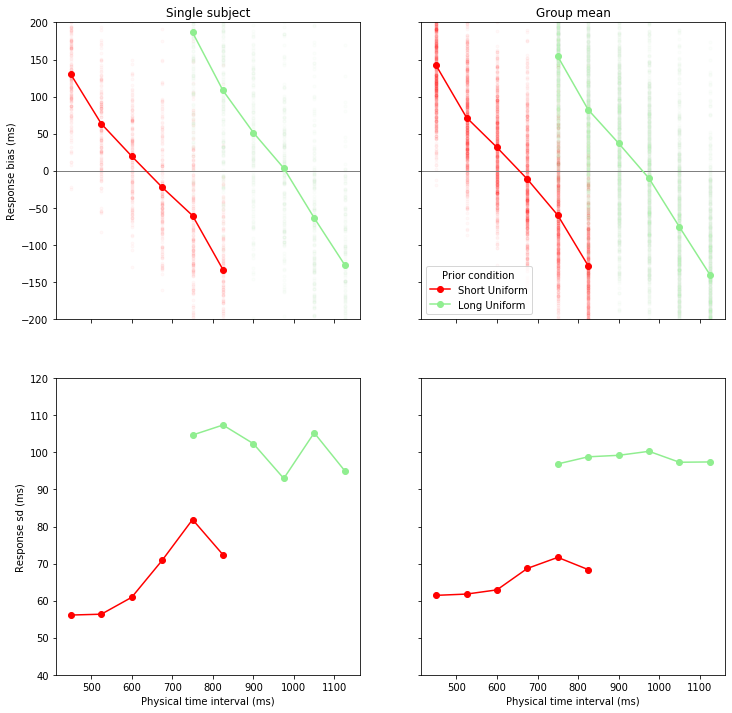

In [16]:
# Plotting Experiment1:

# Remove training trials
dat = df[df['Main'] == True]

# Calculate mean Tp by condition
# mean_bias = dat.groupby(['Cond', 'Ts'])['Bias'].mean().reset_index()
mean_bias = dat.groupby(['Cond', 'Ts'])[['Tp', 'Bias']].agg({'Tp': 'std', 'Bias': 'mean'}).reset_index().rename({'Tp':'Std'}, axis = 1)

yrange = np.multiply((min(mean_bias['Bias']), max(mean_bias['Bias'])), [0.9, 1.1])

# Subset data for plotting

cond1 = mean_bias.loc[mean_bias['Cond'] == "Short Uniform"]
cond2 = mean_bias.loc[mean_bias['Cond'] == "Long Uniform"]
cond3 = mean_bias.loc[mean_bias['Cond'] == "Medium Uniform"]
cond4 = mean_bias.loc[mean_bias['Cond'] == "Medium Peaked"]

# Add jitter noise
jitter = dat.copy()
jitter['Bias'] = jitter['Bias'] + np.random.uniform(-5, 5, len(dat))
cond1_jitter = jitter.loc[jitter['Cond'] == "Short Uniform"]
cond2_jitter = jitter.loc[jitter['Cond'] == "Long Uniform"]
cond3_jitter = jitter.loc[jitter['Cond'] == "Medium Uniform"]
cond4_jitter = jitter.loc[jitter['Cond'] == "Medium Peaked"]

# Make plot
# f, ax = plt.subplots(figsize = (6,6))
f, ax = plt.subplots(2, 2, sharex='all', sharey = 'row', figsize = (12, 12))

# Plot 1 Group Bias right
ax[0, 1].set_title("Group mean")
ax[0, 1].set(ylim = (-200, 200))
ax[0,1].axhline(linewidth=1, color='gray')

ax[0, 1].scatter(cond1_jitter['Ts'], cond1_jitter['Bias'], marker = '.', color = 'red', alpha = 0.025, label = None)
ax[0, 1].scatter(cond2_jitter['Ts'], cond2_jitter['Bias'], marker = '.', color = 'lightgreen', alpha = 0.025, label = None)

ax[0, 1].plot(cond1['Ts'], cond1['Bias'], color = 'red', marker = 'o', label = "Short Uniform" )
ax[0, 1].plot(cond2['Ts'], cond2['Bias'], color = 'lightgreen', marker = 'o', label = "Long Uniform")

ax[0, 1].legend(title = 'Prior condition', loc = 'best')

# Plot 2 Group Std right
ax[1, 1].set(ylim = (40, 120))
ax[1, 1].set_xlabel('Physical time interval (ms)')
# ax[1, 0].scatter(cond1_jitter['Ts'], cond1_jitter['Std'], marker = '.', color = 'red', alpha = 0.025, label = None)
# ax[1, 0].scatter(cond2_jitter['Ts'], cond2_jitter['Std'], marker = '.', color = 'green', alpha = 0.025, label = None)

ax[1, 1].plot(cond1['Ts'], cond1['Std'], color = 'red', marker = 'o', label = "Short Uniform" )
ax[1, 1].plot(cond2['Ts'], cond2['Std'], color = 'lightgreen', marker = 'o', label = "Long Uniform")
## selecting one representative subject:
subject = np.random.choice(dat[(dat.Cond.str.startswith('Long'))|(dat.Cond.str.startswith('Short'))].Subj.unique(), replace = False)

dat_subj = dat[dat.Subj==subject]

# Calculate mean Tp by condition
mean_bias = dat_subj.groupby(['Cond', 'Ts'])[['Tp', 'Bias']].agg({'Tp': 'std', 'Bias': 'mean'}).reset_index().rename({'Tp':'Std'}, axis = 1)


# Subset data for plotting

cond1 = mean_bias.loc[mean_bias['Cond'] == "Short Uniform"]
cond2 = mean_bias.loc[mean_bias['Cond'] == "Long Uniform"]
cond3 = mean_bias.loc[mean_bias['Cond'] == "Medium Uniform"]
cond4 = mean_bias.loc[mean_bias['Cond'] == "Medium Peaked"]

# Add jitter noise
jitter = dat_subj.copy()
jitter['Bias'] = jitter['Bias'] + np.random.uniform(-5, 5, len(dat_subj))
cond1_jitter = jitter.loc[jitter['Cond'] == "Short Uniform"]
cond2_jitter = jitter.loc[jitter['Cond'] == "Long Uniform"]
cond3_jitter = jitter.loc[jitter['Cond'] == "Medium Uniform"]
cond4_jitter = jitter.loc[jitter['Cond'] == "Medium Peaked"]

# Plot 3 Individual bias left
ax[0, 0].set_title("Single subject")
ax[0, 0].set_ylabel('Response bias (ms)')
ax[0,0].axhline(linewidth=1, color='gray')

ax[0, 0].scatter(cond1_jitter['Ts'], cond1_jitter['Bias'], marker = '.', color = 'red', alpha = 0.025, label = None)
ax[0, 0].scatter(cond2_jitter['Ts'], cond2_jitter['Bias'], marker = '.', color = 'lightgreen', alpha = 0.025, label = None)

ax[0, 0].plot(cond1['Ts'], cond1['Bias'], color = 'red', marker = 'o', label = "Short Uniform" )
ax[0, 0].plot(cond2['Ts'], cond2['Bias'], color = 'lightgreen', marker = 'o', label = "Long Uniform")

# Plot 4 Individual Std left
# f.gca().set_aspect('equal', adjustable = 'box')

ax[1, 0].set_xlabel('Physical time interval (ms)')
ax[1, 0].set_ylabel('Response sd (ms)')
# ax[1, 0].scatter(cond1_jitter['Ts'], cond1_jitter['Std'], marker = '.', color = 'red', alpha = 0.025, label = None)
# ax[1, 0].scatter(cond2_jitter['Ts'], cond2_jitter['Std'], marker = '.', color = 'green', alpha = 0.025, label = None)

ax[1, 0].plot(cond1['Ts'], cond1['Std'], color = 'red', marker = 'o', label = "Short Uniform" )
ax[1, 0].plot(cond2['Ts'], cond2['Std'], color = 'lightgreen', marker = 'o', label = "Long Uniform")

f.savefig('plot3.png')

C:\Users\jonas\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\jonas\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\jonas\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


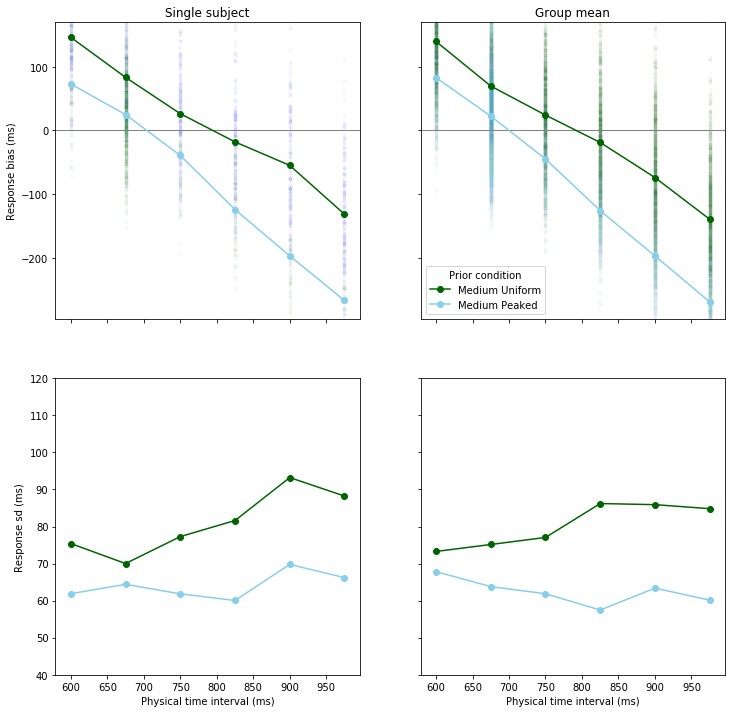

In [17]:
# Plotting Experiment 2:

# Remove training trials
dat = df[df['Main'] == True]

# Calculate mean Tp by condition
# mean_bias = dat.groupby(['Cond', 'Ts'])['Bias'].mean().reset_index()
mean_bias = dat.groupby(['Cond', 'Ts'])[['Tp', 'Bias']].agg({'Tp': 'std', 'Bias': 'mean'}).reset_index().rename({'Tp':'Std'}, axis = 1)

yrange = np.multiply((min(mean_bias['Bias']), max(mean_bias['Bias'])), [1.1, 1.1])

# Subset data for plotting

cond1 = mean_bias.loc[mean_bias['Cond'] == "Short Uniform"]
cond2 = mean_bias.loc[mean_bias['Cond'] == "Long Uniform"]
cond3 = mean_bias.loc[mean_bias['Cond'] == "Medium Uniform"]
cond4 = mean_bias.loc[mean_bias['Cond'] == "Medium Peaked"]

# Add jitter noise
jitter = dat.copy()
jitter['Bias'] = jitter['Bias'] + np.random.uniform(-5, 5, len(dat))
cond1_jitter = jitter.loc[jitter['Cond'] == "Short Uniform"]
cond2_jitter = jitter.loc[jitter['Cond'] == "Long Uniform"]
cond3_jitter = jitter.loc[jitter['Cond'] == "Medium Uniform"]
cond4_jitter = jitter.loc[jitter['Cond'] == "Medium Peaked"]

# Make plot
# f, ax = plt.subplots(figsize = (6,6))
f, ax = plt.subplots(2, 2, sharex='all', sharey='row', figsize = (12, 12))

# Plot 1 Group Bias right
ax[0, 1].set_title("Group mean")
ax[0, 1].set(ylim = yrange)
ax[0,1].axhline(linewidth=1, color='gray')


ax[0, 1].scatter(cond3_jitter['Ts'], cond3_jitter['Bias'], marker = '.', color = 'darkgreen', alpha = 0.025, label = None)
ax[0, 1].scatter(cond4_jitter['Ts'], cond4_jitter['Bias'], marker = '.', color = 'skyblue', alpha = 0.025, label = None)

ax[0, 1].plot(cond3['Ts'], cond3['Bias'], color = 'darkgreen', marker = 'o', label = "Medium Uniform" )
ax[0, 1].plot(cond4['Ts'], cond4['Bias'], color = 'skyblue', marker = 'o', label = "Medium Peaked")


ax[0, 1].legend(title = 'Prior condition', loc = 'best')

# Plot 2 Group Std right
ax[1, 1].set_xlabel('Physical time interval (ms)')
ax[1, 1].set(ylim = (40, 120))

# ax[1, 1].scatter(cond3_jitter['Ts'], cond3_jitter['Std'], marker = '.', color = 'blue', alpha = 0.025, label = None)
# ax[1, 1].scatter(cond4_jitter['Ts'], cond4_jitter['Std'], marker = '.', color = 'green', alpha = 0.025, label = None)

ax[1, 1].plot(cond3['Ts'], cond3['Std'], color = 'darkgreen', marker = 'o', label = "Medium Uniform" )
ax[1, 1].plot(cond4['Ts'], cond4['Std'], color = 'skyblue', marker = 'o', label = "Medium Peaked")

## selecting on represntative subject:
subject = np.random.choice(dat[dat.Cond.str.startswith('Medium')].Subj.unique(), replace = False)


dat_subj = dat[dat.Subj==subject]

# Calculate mean Tp by condition
# mean_bias = dat.groupby(['Cond', 'Ts'])['Bias'].mean().reset_index()
mean_bias = dat_subj.groupby(['Cond', 'Ts'])[['Tp', 'Bias']].agg({'Tp': 'std', 'Bias': 'mean'}).reset_index().rename({'Tp':'Std'}, axis = 1)


# Subset data for plotting

cond1 = mean_bias.loc[mean_bias['Cond'] == "Short Uniform"]
cond2 = mean_bias.loc[mean_bias['Cond'] == "Long Uniform"]
cond3 = mean_bias.loc[mean_bias['Cond'] == "Medium Uniform"]
cond4 = mean_bias.loc[mean_bias['Cond'] == "Medium Peaked"]

# Add jitter noise
jitter = dat_subj.copy()
jitter['Bias'] = jitter['Bias'] + np.random.uniform(-5, 5, len(dat_subj))
cond1_jitter = jitter.loc[jitter['Cond'] == "Short Uniform"]
cond2_jitter = jitter.loc[jitter['Cond'] == "Long Uniform"]
cond3_jitter = jitter.loc[jitter['Cond'] == "Medium Uniform"]
cond4_jitter = jitter.loc[jitter['Cond'] == "Medium Peaked"]

# Plot 3 Individual bias left
ax[0, 0].set_title("Single subject")
ax[0, 0].set_ylabel('Response bias (ms)')
ax[0,0].axhline(linewidth=1, color='gray')

ax[0, 0].scatter(cond3_jitter['Ts'], cond3_jitter['Bias'], marker = '.', color = 'blue', alpha = 0.025, label = None)
ax[0, 0].scatter(cond4_jitter['Ts'], cond4_jitter['Bias'], marker = '.', color = 'green', alpha = 0.025, label = None)

ax[0, 0].plot(cond3['Ts'], cond3['Bias'], color = 'darkgreen', marker = 'o', label = "Medium Uniform" )
ax[0, 0].plot(cond4['Ts'], cond4['Bias'], color = 'skyblue', marker = 'o', label = "Medium Peaked")

# Plot 4 Individual Std left

ax[1, 0].set_xlabel('Physical time interval (ms)')
ax[1, 0].set_ylabel('Response sd (ms)')

# ax[1, 0].scatter(cond3_jitter['Std'], cond3_jitter['Bias'], marker = '.', color = 'blue', alpha = 0.025, label = None)
# ax[1, 0].scatter(cond4_jitter['Std'], cond4_jitter['Bias'], marker = '.', color = 'green', alpha = 0.025, label = None)

ax[1, 0].plot(cond3['Ts'], cond3['Std'], color = 'darkgreen', marker = 'o', label = "Medium Uniform" )
ax[1, 0].plot(cond4['Ts'], cond4['Std'], color = 'skyblue', marker = 'o', label = "Medium Peaked")
f.savefig('plot4.png')